In [133]:
import os
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import torch
from tqdm import tqdm
import numpy as np
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from itertools import combinations

In [134]:
os.environ['HF_HOME'] = '/scratch/' + str(open('../tokens/HPC_ACCOUNT_ID.txt', 'r').read())
cache_dir = '/scratch/' + str(open('../tokens/HPC_ACCOUNT_ID.txt', 'r').read()) + '/cache'
hf_api_key = ""
with open("../tokens/HF_TOKEN.txt", "r") as f:
    hf_api_key = f.read().strip()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sentence_bert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [135]:
DATASET = "LeoZotos/bio_full"
WIKI = "En" # 'En' or 'Simple'
SOURCE_TEXT = ""  # '_Only_Options' # or '' for full text
NUM_DOCS_RETRIEVED = 60 # 20 or 60

HAS_CONTENT_DISTRACTORS = 2 # 0 to 2, -1 for any
SHORT_OPTIONS_THRESHOLD = 10000 # >500 for all options, otherwise 20 or so for short options

RETRIEVED_DOCS_COL_NAME = 'Relevant_Docs_' + WIKI + SOURCE_TEXT + '_' + str(NUM_DOCS_RETRIEVED)

In [136]:
def is_nan_or_none(x):
    return x is None or (isinstance(x, float) and np.isnan(x))

def has_short_options(list_of_options, threshold=20):
    non_empty_options = [option for option in list_of_options if option and not is_nan_or_none(option)]
    avg_length = sum(len(option) for option in non_empty_options) / len(non_empty_options)
    return avg_length < threshold

data = load_dataset(DATASET, split='train', token=hf_api_key, cache_dir=cache_dir)
print("Before filtering, dataset size:", len(data))
data = data.filter(lambda x: 
    not is_nan_or_none(x['Answer_A_Rate']) and
    not is_nan_or_none(x['Answer_B_Rate']) and
    not is_nan_or_none(x['Answer_C_Rate']) and
    not is_nan_or_none(x['Answer_D_Rate'])  # add a not to exclude 4 choice questions
    )

if HAS_CONTENT_DISTRACTORS in [0, 1, 2]:
    data = data.filter(lambda x: x['Has_Content_Distractors'] == HAS_CONTENT_DISTRACTORS)

# Filter out entries based on length of options
if SHORT_OPTIONS_THRESHOLD < 500:
    data = data.filter(lambda x: not has_short_options([x['Answer_A'], x['Answer_B'], x['Answer_C'], x['Answer_D']], SHORT_OPTIONS_THRESHOLD))

print("After filtering, dataset size:", len(data))

Before filtering, dataset size: 778
After filtering, dataset size: 278


# Classify retrieved docs per choice

In [137]:
def print_similarities(similarities, sentences1, sentences2):
    for idx_i, sentence1 in enumerate(sentences1):
        print(sentence1)
        for idx_j, sentence2 in enumerate(sentences2):
            print(f" - {sentence2: <30}: {similarities[idx_i][idx_j]:.4f}")


def classify_docs_per_distractor(row, sentence_bert_model):
    docs_per_choice = {}
    for key in ['Answer_A', 'Answer_B', 'Answer_C', 'Answer_D']:
        if row[key] != "":
                docs_per_choice[key + '_Docs'] = []
    choices_keys = [key[:-5] for key in docs_per_choice.keys()]
    choices_content = [row[key] for key in choices_keys if row[key] != ""]
    embeddings_choices = sentence_bert_model.encode(choices_content)
    embeddings_docs = sentence_bert_model.encode(row[RETRIEVED_DOCS_COL_NAME])
    similarities = sentence_bert_model.similarity(embeddings_choices, embeddings_docs)

    # We now add each doc to the choice with the highest similarity
    for i, doc in enumerate(row[RETRIEVED_DOCS_COL_NAME]):
        max_sim_index = np.argmax(similarities[:, i])
        max_choice = list(docs_per_choice.keys())[max_sim_index]
        docs_per_choice[max_choice].append(doc)
    
    return docs_per_choice

In [138]:
column_names = [f"Answer_{choice}_Docs" for choice in ['A', 'B', 'C', 'D']]
docs_by_choice = {name: [] for name in column_names}

for row in tqdm(data):
    docs_per_choice_for_row = classify_docs_per_distractor(row, sentence_bert_model)
    for name in column_names:
        docs_by_choice[name].append(docs_per_choice_for_row.get(name, []))
        
if column_names[0] in data.column_names:
    data = data.remove_columns(column_names)
    
for name, column_data in docs_by_choice.items():
    data = data.add_column(name, column_data)

100%|██████████| 278/278 [00:59<00:00,  4.64it/s]


In [139]:
# Inspect an instance manually to see if it makes sense
id = 1
print(data[id]['Question_With_Options'], ":", "\n A:", data[id]['Answer_A_Docs'], "\n B:", data[id]['Answer_B_Docs'], "\n C:", data[id]['Answer_C_Docs'], "\n D:", data[id]['Answer_D_Docs'])

# print the lengths of the lists, only for id
print(f"Lengths for ID {id}:")
for name in column_names:
    print(f"{name}: {len(data[id][name])}")

necrosis ___
a) is cell death caused by an injury or a toxic substance
b) is a programmed mechanism of cell death
c) promotes the survival and growth of dendrites
d) promotes the activity of neurons
 : 
 A: ["Suicide gene Cell death can majorly occur by either necrosis or apoptosis. Necrosis occurs when a cell is damaged by an external force, such as poison, a bodily injury, an infection or getting cut off from blood supply. When cells die from necrosis, it's a rather messy affair. The death causes inflammation that can cause further distress of injury within the body. Whereas, apoptosis causes degradation of cellular components without eliciting an inflammatory response.", 'Identification of cell death Necrosis is an unprogrammed death of cells, which involves early plasma membrane changes leading to loss of calcium and sodium imbalance. This causes acidosis, osmotic shock, clumping of chromatin and nuclear pyknosis. These changes are accompanied by a loss of oxidative phosphorylation

# Evaluate Difference between number of docs retrieved per choice

In [140]:
def test_significance_lengths(data):
    lengths_per_choice = {
        'Answer_A': [len(x['Answer_A_Docs']) for x in data],
        'Answer_B': [len(x['Answer_B_Docs']) for x in data],
        'Answer_C': [len(x['Answer_C_Docs']) for x in data],
        'Answer_D': [len(x['Answer_D_Docs']) for x in data],
    }
    if sum(lengths_per_choice['Answer_D']) < 20:  # Check if there are actual data points for Answer_D
        # If not, remove it from the dictionary
        lengths_per_choice.pop('Answer_D')
        print(lengths_per_choice.keys(), "does not contain Answer_D, removing it from the analysis.")
        
    for key, value in lengths_per_choice.items():
        print(f"{key} - Mean: {np.mean(value)}, Std: {np.std(value)}, Min: {np.min(value)}, Max: {np.max(value)}")
    
    return lengths_per_choice

Answer_A - Mean: 27.158273381294965, Std: 18.451086023214298, Min: 0, Max: 60
Answer_B - Mean: 12.586330935251798, Std: 14.565583271340932, Min: 0, Max: 59
Answer_C - Mean: 10.068345323741006, Std: 13.25452297430711, Min: 0, Max: 59
Answer_D - Mean: 10.18705035971223, Std: 13.233143666552637, Min: 0, Max: 60
Pairs to be compared: [('Answer_A', 'Answer_B'), ('Answer_A', 'Answer_C'), ('Answer_A', 'Answer_D'), ('Answer_B', 'Answer_C'), ('Answer_B', 'Answer_D'), ('Answer_C', 'Answer_D')]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Answer_A vs. Answer_B: t-test independent samples, P_val:6.036e-23 t=1.032e+01
Answer_B vs. Answer_C: t-test independent samples, P_val:3.378e-02 t=2.128e+00
Answer_C vs. Answer_D: t-test independent samples, P_val:9.160e-01 t=-1.055e-01
Answer_A vs. Answer_C: t-test independent samples, P_val:7.626e-32 t=1.252e+01
An

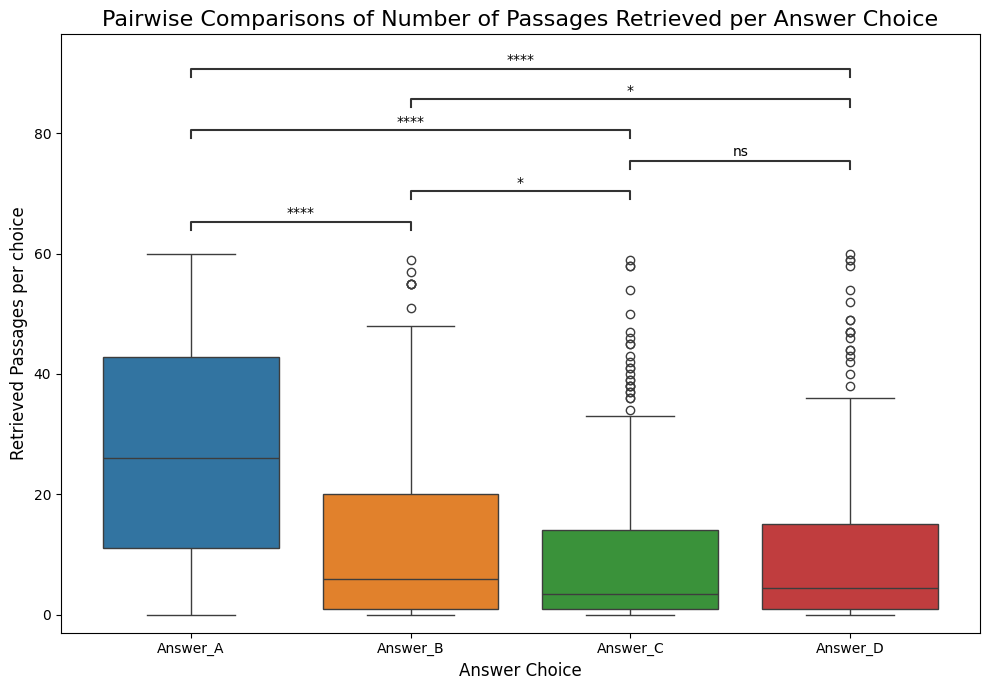

In [141]:
lengths_per_choice = test_significance_lengths(data)

data_tuples = []
for choice, lengths in lengths_per_choice.items():
    for length in lengths:
        data_tuples.append((choice, length))

df = pd.DataFrame(data_tuples, columns=['Choice', 'Length'])

choices = lengths_per_choice.keys()
comparison_pairs = list(combinations(choices, 2))

print("Pairs to be compared:", comparison_pairs)

fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=df, x='Choice', y='Length', ax=ax, hue='Choice')

annotator = Annotator(ax, comparison_pairs, data=df, x='Choice', y='Length')
annotator.configure(test='t-test_ind', text_format='star', verbose=2)

annotator.apply_test().annotate()

ax.set_title('Pairwise Comparisons of Number of Passages Retrieved per Answer Choice', fontsize=16)
ax.set_xlabel('Answer Choice', fontsize=12)
ax.set_ylabel('Retrieved Passages per choice', fontsize=12)
plt.tight_layout()
plt.show()


# Calculate Correlation between choice's selection rate and docs retrieved

In [142]:
selection_rates_with_correct = []
doc_lengths_with_correct = []
print(lengths_per_choice.keys())
for row in data:
    for choice in lengths_per_choice.keys():
        selection_rates_with_correct.append(row[choice + '_Rate'])
        doc_lengths_with_correct.append(len(row[choice + '_Docs']))

correlations_with_correct = {
    'Pearson': pearsonr(selection_rates_with_correct, doc_lengths_with_correct),
    'Spearman': spearmanr(selection_rates_with_correct, doc_lengths_with_correct)
}
print("Correlations with correct answers:")
print(f"Pearson: {correlations_with_correct['Pearson'][0]:.4f} (p={correlations_with_correct['Pearson'][1]:.4f})")
print(f"Spearman: {correlations_with_correct['Spearman'][0]:.4f} (p={correlations_with_correct['Spearman'][1]:.4f})")


selection_rates_without_correct = []
doc_lengths_without_correct = []
choices = [choice for choice in lengths_per_choice.keys() if choice != "Answer_A"]
for row in data:
    for choice in choices:
        selection_rates_without_correct.append(row[choice + '_Rate'])
        doc_lengths_without_correct.append(len(row[choice + '_Docs']))

correlations_without_correct = {
    'Pearson': pearsonr(selection_rates_without_correct, doc_lengths_without_correct),
    'Spearman': spearmanr(selection_rates_without_correct, doc_lengths_without_correct)
}
print("Correlations without correct answers:")
print(f"Pearson: {correlations_without_correct['Pearson'][0]:.4f} (p={correlations_without_correct['Pearson'][1]:.4f})")
print(f"Spearman: {correlations_without_correct['Spearman'][0]:.4f} (p={correlations_without_correct['Spearman'][1]:.4f})")

dict_keys(['Answer_A', 'Answer_B', 'Answer_C', 'Answer_D'])


Correlations with correct answers:
Pearson: 0.4477 (p=0.0000)
Spearman: 0.3715 (p=0.0000)
Correlations without correct answers:
Pearson: 0.1564 (p=0.0000)
Spearman: 0.1294 (p=0.0002)


# Calculate Correlation within each choice

In [143]:
def calc_correlation(type='pearson'):
    simple_list = []
    print(type.capitalize(), "correlation between distractor rates and document lengths(A-D, p-values in between):")
    correlations_with_docs_len = {}

    for choice_name in [f"Answer_{choice}" for choice in ['A', 'B', 'C', 'D']]:
        rates = data[f'{choice_name}_Rate']
        doc_lengths = [len(sentence_list) for sentence_list in data[f'{choice_name}_Docs']]
        correlation, p = None, None
        # count nones in rates and doc_lengths
        print(f"Choice: {choice_name}, Nones in rates: {sum(is_nan_or_none(rate) for rate in rates)}, Nones in doc_lengths: {sum(is_nan_or_none(length) for length in doc_lengths)}")
        
        # if rates has nones ,continue
        if any(is_nan_or_none(rate) for rate in rates):
            correlation, p = 0, 0
        else:
            if type == 'pearson':
                correlation, p = pearsonr(rates, doc_lengths)
            elif type == 'spearman':
                correlation, p = spearmanr(rates, doc_lengths)
        
        correlations_with_docs_len[choice_name] = (round(correlation,4), round(p,4))
        simple_list.append(float(round(correlation,4)))
        simple_list.append(float(round(p,4)))
        
    correlations_string = "\t".join(
        [f"{str(correlation)} {str(p)}"
         for (correlation, p) in correlations_with_docs_len.values()]
    )  
    print(correlations_string)
        
    return simple_list

In [144]:
all_results = []
all_results.extend(calc_correlation('pearson'))
all_results.extend(calc_correlation('spearman'))

# Export to csv
df = pd.DataFrame([all_results], columns=[
    'Pearson_A_Correlation', 'Pearson_A_p', 
    'Pearson_B_Correlation', 'Pearson_B_p', 
    'Pearson_C_Correlation', 'Pearson_C_p', 
    'Pearson_D_Correlation', 'Pearson_D_p',
    'Spearman_A_Correlation', 'Spearman_A_p', 
    'Spearman_B_Correlation', 'Spearman_B_p', 
    'Spearman_C_Correlation', 'Spearman_C_p', 
    'Spearman_D_Correlation', 'Spearman_D_p'
])
df.to_csv('last_correlations.csv', index=False)

Pearson correlation between distractor rates and document lengths(A-D, p-values in between):
Choice: Answer_A, Nones in rates: 0, Nones in doc_lengths: 0
Choice: Answer_B, Nones in rates: 0, Nones in doc_lengths: 0
Choice: Answer_C, Nones in rates: 0, Nones in doc_lengths: 0
Choice: Answer_D, Nones in rates: 0, Nones in doc_lengths: 0
0.1788 0.0028	0.1895 0.0015	0.0781 0.1943	0.1124 0.0613
Spearman correlation between distractor rates and document lengths(A-D, p-values in between):
Choice: Answer_A, Nones in rates: 0, Nones in doc_lengths: 0
Choice: Answer_B, Nones in rates: 0, Nones in doc_lengths: 0
Choice: Answer_C, Nones in rates: 0, Nones in doc_lengths: 0
Choice: Answer_D, Nones in rates: 0, Nones in doc_lengths: 0
0.1809 0.0025	0.0902 0.1335	0.1089 0.0699	0.1691 0.0047
